<a href="https://colab.research.google.com/github/docheem/NLP-Portfolio/blob/main/PR_Question_Answering_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building advanced Review-Based QA System using transformers and Haystack
 we will be:

- Extracting answers from corpus
- Initializing a document store
- Instantiating the model with a QA
  head
- Initializing retriever
  - Sparse
  - Dense passage
- Initializing reader
- Implementating of custom metrics
- Evaluating the Reader
- Evaluating retriever
- Domain Adaptations
- Retrieval-augmented generation  (RAG)
    - Fine-tune RAG token model


To build our QA system we’ll use the SubjQA dataset, which consists of more than 10,000 customer reviews in English about products and services in six domains: Trip Advisor, Restaurants, Movies, Books, Electronics, and Grocery.

In [ ]:
!pip install -q transformers
!pip install -q torch
!pip install datasets
!pip install sentencepiece
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.9 MB/s eta 0:00:00
Looking in index

In [ ]:
# using the get_dataset_config_names() function
# to find out which subsets are available

from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

We’ll focus on building a QA system for the Electronics domain

In [ ]:
# Loading the electronics dataset

from datasets import load_dataset

subjqa = load_dataset("subjqa",
                      name = "electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
subjqa

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

In [ ]:
# inspecting one of the rows in the answers column

mydata = subjqa["train"]["answers"][1]
mydata

{'text': ['Bass is weak as expected',
  'Bass is weak as expected, even with EQ adjusted up'],
 'answer_start': [1302, 1302],
 'answer_subj_level': [1, 1],
 'ans_subj_score': [0.5083333253860474, 0.5083333253860474],
 'is_ans_subjective': [True, True]}

In [ ]:
# converting each split to a Pandas DataFrame
# by flatten these nested columns

import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():

    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


There are quite a few columns in the SubjQA dataset, but we will be using the most interesting ones for building our QA system

- title
- question
- answers.text
- answers.answer_start
- context"

In [ ]:
# We can use the sample() method to select a random sample

qa_cols = ["title",
            "question",
            "answers.text",
            "answers.answer_start",
            "context"]


sample_df = dfs["train"][qa_cols].sample(3, random_state = 7)


sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...
961,B0074BW614,How is the cell phone screen?,[The interface takes a few tries to get used t...,[535],"Don't get me wrong, I love my e-ink kindle to ..."


First, the questions are not grammatically correct, which is quite common in the FAQ sections of ecommerce websites. Second, an empty answers.text entry denotes “unanswerable” questions whose answer cannot be found in the review.

In [ ]:
# use the start index and length of the answer span to slice out
# the span of text in the review that corresponds to the answer


start_idx = sample_df["answers.answer_start"].iloc[0][0]

end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])



sample_df["context"].iloc[0][start_idx:end_idx]


'this keyboard is compact'

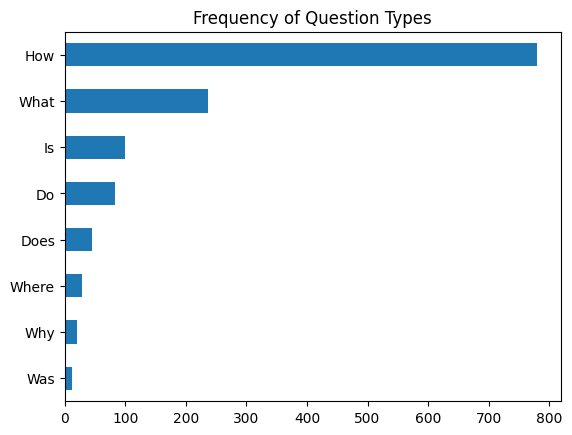

In [ ]:
# counting the questions that begin with a few common starting words

import seaborn as sns
import matplotlib.pyplot as plt

counts = {}

question_types = ["What",
                  "How",
                  "Is",
                  "Does",
                  "Do",
                  "Was",
                  "Where",
                  "Why"]


for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]


pd.Series(counts).sort_values().plot.barh()

plt.title("Frequency of Question Types")

plt.show()

In [ ]:
# some examples of questions that starts with how, what, and is

for question_type in ["How", "What", "Is"]:

  for question in (dfs["train"][dfs["train"].question.str.startswith(question_type)]

                   .sample(n=3, random_state = 42)['question']):

                    print(question)



How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


#Extracting Answers from Text

The first thing we’ll need for our QA system is to find a way to identify a potential answer as a span of text in a customer review.

To do this we’ll need to understand how to:

- Frame the supervised learning problem.
- Tokenize and encode text for QA tasks.
- Deal with long passages that exceed a model’s maximum context size.

For example, if a we have a question like “Is it waterproof?” and the review passage is “This watch is waterproof at 30m depth”, then the model should output “waterproof at 30m”.

Tokenizing text for QA

In [ ]:
# we’ll use a fine-tuned MiniLM model since it is fast to train


from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"


tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


In [ ]:
# lets see the model in action
# extracting an answer from a short passage of text.

question = "How much music can this hold?"


context = """An MP3 is about 1 MB/minute,
so about 6000 hours depending on \ file size."""


inputs = tokenizer(question,
                   context,
                   return_tensors = "pt")


pd.DataFrame([inputs]).T

,0
attention_mask,"[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
input_ids,"[[tensor(101), tensor(2129), tensor(2172), ten..."
token_type_ids,"[[tensor(0), tensor(0), tensor(0), tensor(0), ..."


0 indicates a question token, a 1 indicates a context token in the token_type_ids.

In [ ]:
# Decoding the input_ids tensor

print(tokenizer.decode(inputs["input_ids"][0]))


[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on \ file size. [SEP]


Instantiating the model with a QA head and run the inputs through the forward pass.

In [ ]:
# Instantiating with AutoModelForQuestionAnswering QA Head

import torch
from transformers import AutoModelForQuestionAnswering

#QA Head
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():

  #forward pass
  outputs = model(**inputs)

print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.7600, -4.7565, -5.4027, -5.2368, -5.2771, -5.4985, -4.9769, -6.1621,
         -0.7600,  0.6527,  0.0474, -1.4596,  4.0708,  5.2617, -0.7022, -3.8406,
         -1.4190, -4.6270, -1.4310,  3.7721,  4.5929, -0.3631, -3.3237, -5.1965,
         -3.1124, -3.4640, -4.2704, -4.4887, -0.7600]]), end_logits=tensor([[-0.7715, -5.4826, -5.0251, -5.1502, -5.4228, -5.5347, -5.1739, -4.6997,
         -0.7715, -3.6354, -0.5732, -3.6876, -2.8507, -0.8947,  0.6139, -2.4160,
          5.4288,  0.2895, -3.0944, -3.3933,  0.7722,  5.4368, -0.8595, -5.0447,
         -4.4632, -4.1436, -1.1829, -0.3302, -0.7715]]), hidden_states=None, attentions=None)


The QA head corresponds to a linear layer that takes the hidden states from the encoder and computes the logits for the start and end spans.This means that we treat QA as a form of token classification

In [ ]:
# To convert the outputs into an answer span,
# we first need to get the logits for the start and end tokens

start_logits = outputs.start_logits

end_logits = outputs.end_logits

It's often useful to know exactly which part of the input text the model used to generate that summary or answer. By converting the model's output into an answer span, we can see the specific sequence of tokens that the model used to generate the summary or answer.

In [ ]:
print(f"Input IDs shape: {inputs.input_ids.size()}")

print(f"Start logits shape: {start_logits.size()}")

print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 29])
Start logits shape: torch.Size([1, 29])
End logits shape: torch.Size([1, 29])


To get the final answer, we can compute the argmax over the start and end token logits and then slice the span from the inputs

In [ ]:
import torch



start_idx = torch.argmax(start_logits)


end_idx = torch.argmax(end_logits) + 1



answer_span = inputs["input_ids"][0][start_idx:end_idx]


answer = tokenizer.decode(answer_span)



print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 1 mb / minute, so about 6000 hours


In [ ]:
# instantiate the pipeline by passing our tokenizer and fine-tuned model


from transformers import pipeline

pipe = pipeline("question-answering",
                model = model,
                tokenizer = tokenizer)

pipe(question = question,
     context = context,
     topk = 3)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:323: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.23802025616168976,
  'start': 16,
  'end': 49,
  'answer': '1 MB/minute, \nso about 6000 hours'},
 {'score': 0.2361302375793457,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'},
 {'score': 0.12195158004760742,
  'start': 39,
  'end': 49,
  'answer': '6000 hours'}]

# Dealing with long passages

One subtlety faced by reading comprehension models is that the context often contains more tokens than the maximum sequence length of the model (which is usually a few hundred tokens at most).


For other tasks, like text classification, we simply truncated long texts.

For QA, however, this strategy is problematic because the answer to a question could lie near the end of the context and thus would be removed by truncation

The standard way to deal with this is to apply a sliding window across the inputs, where each window contains a passage of tokens that fit in the model’s context.

In [ ]:
# we can set return_overflowing_tokens = True
# in the tokenizer to enable the sliding window.

example = dfs["train"].iloc[0][["question",
                                "context"]]


tokenized_example = tokenizer(example["question"],
                              example["context"],
                              return_overflowing_tokens = True, # Enabling the sliding window
                              max_length = 100, # size of sliding window
                              stride = 25)


In [ ]:
# check the number of tokens we have in each window

for idx, window in enumerate(tokenized_example["input_ids"]):

  print(f"Window #{idx} has {len(window)} tokens")


Window #0 has 100 tokens
Window #1 has 88 tokens


In [ ]:
# see where two windows overlap by decoding the inputs

for window in tokenized_example["input_ids"]:

  print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



# Using Haystack to Build an end to end QA Pipeline

To build our QA system, we’ll use the Haystack library developed by deepset.

In [ ]:
# Installing elasticsearch

!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.9.2


In [ ]:
# Starting the Elasticsearch server.

import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2

es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout = PIPE,
                  stderr = STDOUT,
                  preexec_fn = lambda: os.setuid(1)) # Wait until Elasticsearch has started
!sleep 30


In [ ]:
# test the connection by sending an HTTP request to localhost

!curl -X GET "localhost:9200/?pretty"

{
  "name" : "e044892eb666",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "2Y8YakjsTjGt6x-QK8Lzxg",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
!pip install --upgrade pip
!pip install farm-haystack[colab]
!pip install 'elasticsearch==7.13.4'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 713.1/713.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.9/299.9 kB 30.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
# Initializing a document store
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)



TypeError: ignored

By default, ElasticsearchDocumentStore creates two indices on Elasticsearch:
- one called document for storing documents
- and another called label for storing the annotated answer spans.

In [ ]:
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents(index="document")
    document_store.delete_documents(index="label")

In [ ]:
subjqa

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

In [ ]:
# df is assign to dfs and dfs is assign to subjqa dataset

for split, df in dfs.items():

    # Exclude duplicate reviews
    docs = [{"content": row["context"],

             "id": row["review_id"],

             "meta":{"item_id": row["title"],
                     "question_id": row["id"],
                     "split": split}}

        for _,row in df.drop_duplicates(subset="context").iterrows()]

    document_store.write_documents(documents = docs,
                                   index = "document")

print(f"Loaded {document_store.get_document_count()} documents")


Loaded 1615 documents


we’ve loaded all our reviews into an index. To search the index we’ll need a retriever, so let’s look at how we can initialize one for Elasticsearch.


#Initializing a retriever

The BM25 score measures how much matched text is about a search query and improves on TF-IDF by saturating TF values quickly and normalizing the document length so that short documents are favored over long ones.

In [ ]:
# initializing class by specifying the document store we wish to search over

from haystack.nodes import BM25Retriever

es_retriever = BM25Retriever(document_store=document_store)


let’s look at a simple query for a single electronics product in the training set. For review-based QA systems like we're building, it’s important to restrict the queries to a single item because otherwise the retriever would source reviews about products that are not related to a user’s query. For example, asking “Is the camera quality any good?” without a product filter could return reviews about phones, when the user might be asking about a specific laptop camera instead.

In [ ]:
# simple query example

item_id = "B0074BW614"


query = "Is it good for reading?"

# using the retriever’s retrieve() method
retrieved_docs = es_retriever.retrieve(query = query,
                                       top_k = 3,
                                       filters = {"item_id":[item_id],
                                                  "split":["train"]})

we’ve specified how many documents to return with the top_k argument and applied a filter on both the item_id and split keys that were included in the meta field of our documents.

In [ ]:
# result
pd.DataFrame([retrieved_docs[0]])

,id,content,content_type,meta,id_hash_keys,score,embedding
0,4a6aa9c7808ebba8d35aeecbcc3c30fe,This is a gift to myself. I have been a kindle user for 4 years and this is...,text,"{'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3',...",[content],0.685782,None


In addition to the document’s text, we can see the score computed (larger scores imply a better match)

Now that we have a way to retrieve relevant documents, the next thing we need is a way to extract answers from them

#Initializing a reader

In Haystack, there are two types of readers one can use to extract answers from a given context:

- FARMReader is like a person who reads the entire book and remembers everything that happened.

- TransformersReader is like a team of people who work together. Each person reads part of the book and remembers everything that happened in that part.

We’ll use the FARMReader

In [ ]:
from haystack.nodes import FARMReader

# Loading model
model_ckpt = "deepset/minilm-uncased-squad2"


max_seq_length, doc_stride = 384, 128

# Initiating FARMReader
reader = FARMReader(model_name_or_path = model_ckpt,

                    progress_bar = False,

                    max_seq_len = max_seq_length,

                    doc_stride = doc_stride,

                    return_no_answer = True)

In [ ]:
# let’s now test the reader on our simple example from earlier

pd.DataFrame([reader.predict_on_texts(question = question,
                              texts = [context],
                              top_k = 1)])

,query,no_ans_gap,answers
0,How much music can this hold?,12.229922,"[<Answer: answer='1 MB/minute, \nso about 6000 hours', score=0.4859600663185..."


the reader appears to be working as expected

#Using one of Haystack’s pipelines

Haystack provides a Pipeline abstraction that allows us to combine retrievers, readers, and other components together as a graph that can be easily customized for each use case.

In [ ]:
from haystack.pipelines import ExtractiveQAPipeline

#es_retriever = BM25Retriever(document_store=document_store)

pipe = ExtractiveQAPipeline(reader, es_retriever)


In [ ]:
# simple example using our question about the Amazon Fire tablet again,
# but this time returning the extracted answers


n_answers = 3

preds = pipe.run(query = query, params={"Retriever": {"top_k": 3,

                                                    "filters":{"item_id": [item_id],

                                                               "split":["train"]}},

                                      "Reader": {"top_k": n_answers}})


print(f"Question: {preds['query']} \n")


for idx in range(n_answers):

    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")

    print(f"Review snippet: ...{preds['answers'][idx].context}...")

    print("\n\n")


Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





We now have an end-to-end QA system for Amazon product reviews!

#Improving Our QA Pipeline
# Evaluating the Retriever

To measure the fraction of all relevant documents, we can compute recall by counting the number of times an answer appears in the top k documents returned by the retriever.

Implementation of custom metrics and query flows.

Comparing the performance of sparse and dense representations.



In [ ]:
from haystack.pipelines import DocumentSearchPipeline
from haystack.nodes import BM25Retriever

pipe = DocumentSearchPipeline(retriever = es_retriever)

In [ ]:
# using the EvalRetriever class whose run() method keeps
# track of which documents have answers that match the ground truth.

from haystack.pipeline import Pipeline
from haystack.eval import EvalDocuments

class EvalRetrieverPipeline:

    def __init__(self, retriever):

        self.retriever = retriever

        # method keeps track of which documents have answers that match the ground truth
        self.eval_retriever = EvalDocuments()


        pipe = Pipeline()


        pipe.add_node(component = self.retriever,

                      name = "ESRetriever",

                      inputs = ["Query"])


        pipe.add_node(component=self.eval_retriever,

                      name = "EvalRetriever",

                      inputs = ["ESRetriever"])


        self.pipeline = pipe

In [ ]:
pipe = EvalRetrieverPipeline(es_retriever)

In [ ]:


from haystack import Label, Answer, Document



labels = []

# df is assign to dfs and dfs is assign to subjqa dataset
for i, row in dfs["test"].iterrows():

    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}

    # Populate labels for questions with answers
    if len(row["answers.text"]):

        for answer in row["answers.text"]:

            label = Label(query = row["question"],

                          answer = Answer(answer = answer),

                          origin = "gold-label",

                          document = Document(content = row["context"],
                                              id = row["review_id"]),
                          meta = meta,

                          is_correct_answer = True,

                          is_correct_document=True,

                          no_answer = False,

                          filters = {"item_id": [meta["item_id"]],
                                     "split":["test"]})

            labels.append(label)


    # Populate labels for questions without answers
    else:
        label = Label(query = row["question"],

                      answer = Answer(answer =""),

                      origin = "gold-label",

                      document = Document(content = row["context"],

                                          id = row["review_id"]),

                      meta = meta,

                      is_correct_answer = True,

                      is_correct_document = True,

                      no_answer = True,

                      filters = {"item_id": [row["title"]],
                                 "split":["test"]})
        labels.append(label)


In [ ]:
pd.DataFrame([labels[0]])

,id,query,document,is_correct_answer,is_correct_document,origin,answer,pipeline_id,created_at,updated_at,meta,filters
0,c0890bd7-ef9f-43ab-87c9-f55ebfc0684e,What is the tonal balance of these headphones?,"{'id': 'f011c75fb8d26066217e64b3ff470d84', 'content': 'I have been a headpho...",True,True,gold-label,"{'answer': 'I have been a headphone fanatic for thirty years', 'type': 'extr...",None,2023-03-29 03:01:58,None,"{'item_id': 'B00001WRSJ', 'question_id': 'd0781d13200014aa25860e44da9d5ea7'}","{'item_id': ['B00001WRSJ'], 'split': ['test']}"


we can see the question-answer pair, along with an origin field that contains the unique question ID

In [ ]:
# write label index on Elasticsearch

document_store.write_labels(labels,
                            index = "label")

print(f"""Loaded {document_store.get_label_count(index = "label")} \question-answer pairs""")



Loaded 455 \question-answer pairs


Building up a mapping between our question IDs and corresponding answers that we can pass to the pipeline

In [ ]:
# Matching question ID and answerd

labels_agg = document_store.get_all_labels_aggregated(index="label",
                                                      open_domain = True,
                                                      aggregate_by_meta = ["item_id"])
print(len(labels_agg))

330


In [ ]:
pd.DataFrame([labels_agg[109]])

,0
0,<MultiLabel: {'labels': [<Label: {'id': '4ccc8b58-8808-4ddf-bbce-371623b9d13...


Let’s run a  haystck pipeline a function that feeds each question-answer pair associated with each product to the evaluation pipeline and tracks the correct retrievals in our pipe object

In [ ]:
# We can run the pipeline with the desired top_k value like this
eval_result = pipe.eval(labels = labels_agg,
                        params = {"Retriever": {"top_k": 3}})

metrics = eval_result.calculate_metrics()


In [ ]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.96


Notice that we picked a specific value for top_k_retriever to specify the number of documents to retrieve

increasing top_k_retriever parameter will improve the recall, but at the expense of providing more documents to the reader and slowing down the end-to-end pipeline. To guide our decision on which value to pick, we’ll create a function that loops over several k values and compute the recall across the whole test set for each k.

In [ ]:
def evaluate_retriever(retriever,
                       topk_values = [1,3,5,10,20]):

    topk_results = {}

    # Calculate max top_k
    max_top_k = max(topk_values)

    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)

    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(labels = labels_agg,
                         params = {"Retriever": {"top_k": max_top_k}})

    # Calculate metric for each top_k value
    for topk in topk_values:

        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)

        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}

    return pd.DataFrame.from_dict(topk_results,
                                  orient="index")


bm25_topk_df = evaluate_retriever(es_retriever)


/usr/local/lib/python3.9/dist-packages/haystack/schema.py:1489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.9/dist-packages/haystack/schema.py:1489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.9/dist-packages/haystack/schema.py:1489: SettingWithCopyWarning: 
A value is trying to be set on a copy

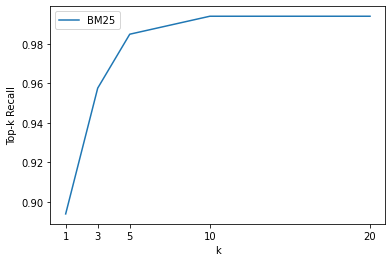

In [ ]:

def plot_retriever_eval(dfs, retriever_names):

    fig, ax = plt.subplots()

    for df, retriever_name in zip(dfs, retriever_names):

        df.plot(y="recall",
                ax = ax,
                label = retriever_name)

    plt.xticks(df.index)

    plt.ylabel("Top-k Recall")
    plt.xlabel("k")

    plt.show()

plot_retriever_eval([bm25_topk_df], ["BM25"])

From the plot, we can see that there’s an inflection point around k = 5 and we get almost perfect recall from k = 10 onwards

# Dense Passage Retrieval

State of the art architecture, Dense Passage Retrieval

We’ve seen that we get almost perfect recall when our sparse retriever returns k = 10 documents, but can we do better at smaller values of k? The advantage of doing so is that we can pass fewer documents to the reader and thereby reduce the overall latency of our QA pipeline.

The main idea behind DPR is to use two BERT models as encoders for the question and the passage. These encoders map the input text into a d-dimensional vector representation of the [CLS] token

In [ ]:
# Using encoders that have been fine-tuned on the NQ corpus

from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store = document_store,

                                      query_embedding_model = "facebook/dpr-question_encoder-single-nq-base",

                                      passage_embedding_model = "facebook/dpr-ctx_encoder-single-nq-base",

                                      embed_title = False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


The next step is to iterate over all the indexed documents in our Elasticsearch index and apply the encoders to update the embedding representation

In [ ]:
document_store.update_embeddings(retriever = dpr_retriever)


Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

/usr/local/lib/python3.9/dist-packages/haystack/schema.py:1489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.9/dist-packages/haystack/schema.py:1489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.9/dist-packages/haystack/schema.py:1489: SettingWithCopyWarning: 
A value is trying to be set on a copy

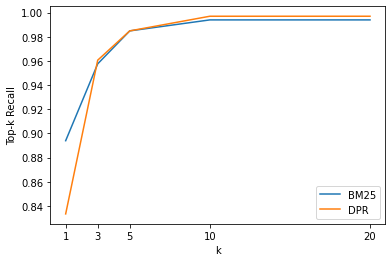

In [ ]:
es_topk_df = evaluate_retriever(es_retriever)



dpr_topk_df = evaluate_retriever(dpr_retriever)



plot_retriever_eval([es_topk_df,

                     dpr_topk_df],

                    ["BM25", "DPR"])

Here we can see that DPR does not provide a boost in recall over BM25 and saturates around k = 3.

# Evaluating the Reader

In extractive QA, there are two main metrics that are used for evaluating readers.
- Exact Match (EM): A binary metric that gives EM = 1 if the characters in the predicted and ground truth answers match exactly, and EM = 0 otherwise

- F1-score : Measures the harmonic mean of the precision and recall.


In [ ]:
!pip install farm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached farm-0.8.0-py3-none-any.whl (204 kB)
  Using cached mlflow-1.13.1-py3-none-any.whl (14.1 MB)
  Using cached boto3-1.26.101-py3-none-any.whl (135 kB)
  Using cached Flask_Cors-3.0.10-py2.py3-none-any.whl (14 kB)
  Using cached flask_restplus-0.13.0-py2.py3-none-any.whl (2.5 MB)
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.1/804.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 73.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.8/387.8 kB 39.9 MB/s eta 0:0

In [ ]:
from farm.evaluation.squad_evaluation import compute_f1, compute_exact

pred = "about 6000 hours"

label = "6000 hours"

print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8



Functions first
- normalize the prediction
- label by
    - removing punctuation
    - fixing whitespace,
    - converting to lowercase.

The normalized strings are then tokenized as a bag-of-words, before finally computing the metric at the token level.

EM is a much stricter metric than the F1-score:
adding a single token to the prediction gives an EM of zero. On the other hand, the F1-score can fail to catch truly incorrect answers.

In [ ]:
pred = "about 6000 dollars"

print(f"EM: {compute_exact(label, pred)}")

print(f"F1: {compute_f1(label, pred)}")


EM: 0
F1: 0.4


Tracking both metrics is a good strategy to balance the trade-off between underestimating (EM) and overestimating (F1-score) model performance.

To evaluate the reader we’ll create a new pipeline with two nodes: a reader node and a node to evaluate the reader. We’ll use the EvalReader class that takes the predictions from the reader and computes the corresponding EM and F1 scores. To compare with the SQuAD evaluation, we’ll take the best answers for each query with the top_1_em and top_1_f1 metrics that are stored in EvalAnswers:

In [ ]:
from haystack.pipelines import Pipeline


def evaluate_reader(reader):

    score_keys = ['exact_match', 'f1']

    p = Pipeline()


    #Reader node
    p.add_node(component = reader,
               name = "Reader",
               inputs = ["Query"])

    # Node to evaluate the reader
    eval_result = p.eval(labels = labels_agg,
                         documents = [[label.document for label in multilabel.labels] for multilabel in labels_agg],
                         params = {})

    metrics = eval_result.calculate_metrics(simulated_top_k_reader = 1)

    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}


reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

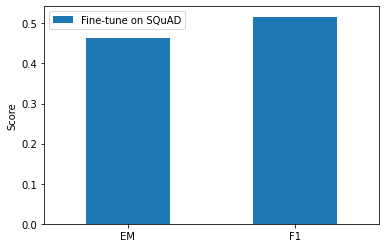

In [ ]:
# plotting readers evaluations

def plot_reader_eval(reader_eval):

    fig, ax = plt.subplots()

    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])

    df.plot(kind = "bar",
            ylabel = "Score",
            rot = 0,
            ax = ax)

    ax.set_xticklabels(["EM", "F1"])

    plt.legend(loc = 'upper left')

    plt.show()

plot_reader_eval(reader_eval)

It seems that the fine-tuned model performs significantly worse on SubjQA than on SQuAD 2.0, where MiniLM achieves EM and F1 scores of 76.1 and 79.5, respectively.

# Domain Adaptation

In [ ]:
def create_paragraphs(df):

    paragraphs = []

    id2context = dict(zip(df["review_id"],
                          df["context"]))

    for review_id, review in id2context.items():

        qas = []

        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")

        id2question = dict(zip(review_df["id"],
                               review_df["question"]))

        # Build up the qas array
        for qid, question in id2question.items():

            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")

            ans_start_idxs = question_df["answers.answer_start"][0].tolist()

            ans_text = question_df["answers.text"][0].tolist()


            # Fill answerable questions
            if len(ans_start_idxs):

                answers = [{"text": text,
                            "answer_start": answer_start}
                    for text, answer_start in zip(ans_text,
                                                  ans_start_idxs)]

                is_impossible = False

            else:
                answers = []
                is_impossible = True

            # Add question-answer pairs to qas
            qas.append({"question": question,
                        "id": qid,
                        "is_impossible": is_impossible,
                        "answers": answers})

        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas,
                           "context": review})

    return paragraphs

In [ ]:
product = dfs["train"].query("title == 'B00001P4ZH'")

pd.DataFrame(create_paragraphs(product))

,qas,context
0,"[{'question': 'How is the bass?', 'id': '2543d296da9766d8d17d040ecc781699', ...","I have had Koss headphones in the past, Pro 4AA and QZ-99. The Koss Portapr..."
1,"[{'question': 'Is this music song have a goo bass?', 'id': 'd476830bf9282e2b...","To anyone who hasn't tried all the various types of headphones, it is import..."
2,"[{'question': 'How is the bass?', 'id': '455575557886d6dfeea5aa19577e5de4', ...","I have had many sub-$100 headphones from $5 Panasonic to $100 Sony, with Sen..."


In [ ]:
# apply this function to each product ID
# by using convert_to_squad()and stores the
# result in an electronics-{split}.json file


import json

def convert_to_squad(dfs):

    for split, df in dfs.items():

        subjqa_data = {}

        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs).to_frame(name = "paragraphs").reset_index())

        subjqa_data["data"] = groups.to_dict(orient="records")

        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:

            json.dump(subjqa_data, f)

convert_to_squad(dfs)





Let’s fine-tune our reader by specifying the locations of the train and dev splits, along with where to save the fine-tuned model

In [ ]:
train_filename = "electronics-train.json"

dev_filename = "electronics-validation.json"


reader.train(data_dir = ".",
             use_gpu = True,
             n_epochs = 1,
             batch_size = 16,
             train_filename = train_filename,
             dev_filename = dev_filename)


Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]

Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
ERROR:haystack.modeling.data_handler.processor:Unable to convert 5 samples to features. Their ids are : 471-0-0, 60-0-0, 75-0-0, 83-0-0, 143-0-0


Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

ERROR:haystack.modeling.data_handler.processor:Unable to convert 5 samples to features. Their ids are : 471-0-0, 83-0-0, 143-0-0, 60-0-0, 75-0-0


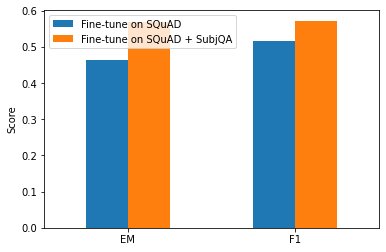

In [ ]:
# compare its performance on the test set against our baseline model

reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)

plot_reader_eval(reader_eval)

Domain adaptation has increased our EM score by a factor of six and more than doubled the F1-score.

Let’s take a look at what naive fine-tuning produces

In [ ]:
# we’ll load up the model with the FARMReader


minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"

minilm_reader = FARMReader(model_name_or_path = minilm_ckpt,

                           progress_bar  =False,

                           max_seq_len = max_seq_length,

                           doc_stride = doc_stride,

                           return_no_answer=True)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# we fine-tune for one epoch

minilm_reader.train(data_dir = ".",

                    use_gpu = True,

                    n_epochs = 1,

                    batch_size = 16,

                    train_filename = train_filename,

                    dev_filename = dev_filename)


Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]

Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
ERROR:haystack.modeling.data_handler.processor:Unable to convert 5 samples to features. Their ids are : 471-0-0, 60-0-0, 75-0-0, 83-0-0, 143-0-0


Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

ERROR:haystack.modeling.data_handler.processor:Unable to convert 5 samples to features. Their ids are : 471-0-0, 83-0-0, 143-0-0, 60-0-0, 75-0-0


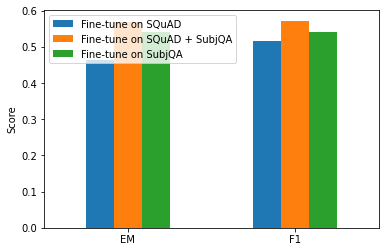

In [ ]:
# include the evaluation on the test set:

reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)

plot_reader_eval(reader_eval)

Results seems a little bit better



# Evaluating the Whole QA Pipeline

Putting it all together

In [ ]:

from haystack.pipelines import ExtractiveQAPipeline


pipe = ExtractiveQAPipeline(retriever = es_retriever,
                            reader = reader)

# Evaluate!
eval_result = pipe.eval(labels = labels_agg,
                        params = {})

metrics = eval_result.calculate_metrics(simulated_top_k_reader = 1)


# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {k:v for k,v in metrics["Reader"].items()

    if k in ["exact_match", "f1"]}

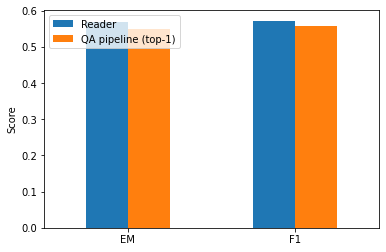

In [ ]:

#id reader-vs-pipeline
#caption Comparison of EM and _F_~1~ scores for the reader against the whole QA pipeline

plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"],

                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

# Retrieval-augmented generation (RAG)

Generative QA with a pretrained language model

Abstractive or generative QA and has the potential to produce better-phrased answers that synthesize evidence across multiple passages.

RAG extends the classic retriever-reader architecture that we’ve seen, by swapping the reader for a generator and using DPR as the retriever. The generator is a pretrained sequence-to-sequence transformer like T5 or BART that receives latent vectors of documents from DPR and then iteratively generates an answer based on the query and these documents.

In [ ]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.27.3-py3-none-any.whl (6.8 MB)
  Using cached huggingface_hub-0.13.3-py3-none-any.whl (199 kB)
  Using cached tokenizers-0.13.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.8
    Uninstalling huggingface-hub-0.0.8:
      Successfully uninstalled huggingface-hub-0.0.8
  Attempting uninstall: transformers
    Found existing installation: transformers 4.6.1
    Uninstalling transformers-4.6.1:
      Successfully uninstalled transformers-4.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the

In [ ]:
# we’ll use the token model that was fine-tuned on NQ as our generator

from transformers import RagTokenizer, RagRetriever, RagTokenForGeneration



generator = RagTokenForGeneration.from_pretrained("facebook/rag-token-nq",
                                                  use_gpu = True)


tokenizer = RagTokenizer.from_pretrained("facebook/rag-token-nq")


retriever = RagRetriever.from_pretrained("facebook/rag-token-nq",
                                         index_name = "exact",
                                         use_gpu = True)



generator = RAGenerator(generator = generator,

                        tokenizer = tokenizer,

                        retriever = retriever,

                        embed_title = True,

                        top_k = 1,

                        max_length = 200,

                        min_length = 2,

                        num_beams = 5)





In [ ]:
from haystack import Pipeline
from haystack import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator = generator, retriever = dpr_retriever)

In [ ]:
# Fine-tuning rag

def generate_answers(query, top_k_generator=3):

  preds = pipe.run(query = query,

                   top_k_generator = top_k_generator,

                   top_k_retriever = 5,

                   filters = {"item_id":["B0074BW614"]})


  print(f"Question: {preds['query']} \n")

  for idx in range(top_k_generator):

      print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")

In [ ]:
generate_answers(query)

In [ ]:
generate_answers("What is the main drawback?")